# Empirical Estimation of Membrane Model Transport Parameters and Performing Model Comparison
Prepared by Tiago Thomaz Migliati Zanon (tmigliat@nd.edu) and Pratham Singh (psingh4@nd.edu)

**Reference:** The problem is inspired by this research paper: *Haim, O.P., et al., “The adverse effect of concentration polarization on ion-ion selectivity in Nanofiltration” Environmental Science and Technology Letters, 2023 10 (4), 363-371, https://doi.org/10.1021/acs.estlett.3c00124

**Objectives:**

1.   Apply knowledge of non-linear regression to find empirical parameters of a
     membrane mass transport model.
2.   Compare two membrane transport models.
3.   Plot and visualize the data.

**Target Audience:** Chemical engineering students.

**Helpful Notebooks to Reference:**
https://ndcbe.github.io/data-and-computing/notebooks/15/Nonlinear-Regression.html



# Overview: Membrane Transport Model Problem

In the realm of pressure-driven membrane processes, the membrane transport model is crucial for design, development, and optimization. The prevalent Solution Diffusion (SD) model, widely integrated into industrial software, serves as a cornerstone. Another common membrane transport model is Speigler Kedem (SK) Model.



To validate the applicability of these model, a researcher conducted a specific experiment focusing on Cesium Chloride salt within a nanofiltration filtration system. This experiment involved varied constant flux settings, allowing the observation and measurement of salt rejection across these different flux conditions. The outcomes provide insights into the performance and behavior of the membrane in relation to salt rejection at varying flux. The flux and rejection data is provided in the table below:


| Flux (m/s) | Rejection |
|-|-|
| 0.000101 | 0.711336|
| 9.66E-05 | 0.725415|
|0.000106  | 0.693630|
|7.97E-05  | 0.711082|
|7.62E-05	 | 0.728779|
|8.36E-05	 | 0.699976|
|5.54E-05	 | 0.702056|
|5.33E-05	 | 0.705363|
|5.75E-05	 | 0.669026|
|3.08E-05	 | 0.637065|
|2.94E-05	 | 0.646364|
|3.18E-05	 | 0.598409|
|4.62E-06	 | 0.408793|
|4.39E-06	 | 0.299547|
|4.71E-06	 | 0.290317|

Based on the data provided above we will estimate the salt permeability $ω$ and mass transfer coefficient $k$ using the Solution Diffusion (SD) model and Speigler Kedem (SK) Model.


# Import Libraries

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.stats.distributions import  t
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brute, fmin, fminbound

##1. Solution Diffusion Model

**Solution Diffusion Model:** The solution-diffusion model is a widely accepted theory that explains the mechanism of membrane transport, particularly in processes like nanofiltration, gas permeation, and dialysis. This model describes how substances move across a semipermeable membrane based on two steps: partioning and diffusion. The governing equation for the model is given below:

$$
\frac{Rs}{1 - Rs} = J \omega e^{\frac{J}{k}}
$$


The Solution Diffusion (SD) model, expressed by the equation, encapsulates the relationship between salt rejection **Rs** and volumetric flux **J**. In this equation, **Rs** denotes the salt rejection while **J** represents the volumetric flux. The exponent **k** embodies a crucial parameter called mass transfer coefficient.

###1a. Define SD Model

In [2]:
# Add Given Values
J = np.array([0.000100556, 9.65556E-05, 0.000106222, 7.96667E-05, 7.62222E-05, 8.35556E-05, 5.54074E-05, 5.32593E-05, 5.74815E-05, 3.08148E-05, 2.94074E-05, 3.17778E-05, 4.62222E-06, 4.38889E-06, 4.71111E-06, ])
Rs = np.array([0.711335686, 0.725415137, 0.693629708, 0.711081808, 0.728778719, 0.699976459, 0.702056047, 0.705362585, 0.669026222, 0.637064923, 0.646363643, 0.598409327, 0.408793422, 0.299546904, 0.290317167, ])

# Convert Rs to Y, where Y is Rs/1-Rs
Y = Rs/(1-Rs)

# Print Y
print('Y =',Y)

# Define SD model function
def SD_Model(theta, J_vals):
  '''
    Function to define SD model
    Arguments:
        J: Volumetric Flux in m/s
        Omega: Salt permeability to be fitted
        k: Mass Transfer coefficient to be fitted by regression
    Returns:
        model: computed value of Rejection by Passage i.e., Y

  '''
  omega, k = theta
  Y_vals = J_vals / (omega * np.exp(J_vals / k))
  return Y_vals

def regression_model(theta, J_vals, data):
    Y_pred = SD_Model(theta, J_vals)
    return data - Y_pred


Y = [2.46423147 2.64186135 2.26402405 2.46118738 2.68702631 2.33307179
 2.35633595 2.39400208 2.02138739 1.75531373 1.82776355 1.49009767
 0.69145615 0.42764734 0.40908016]


###1b. Perform Non-Linear Regresssion



Next, our approach involves non-linear regression through least squares. In Python, the `scipy.optimize` library offers a range of tools tailored for this purpose. Among these tools, the `least_squares` function in this problem. It facilitates the precise fitting of a user-defined function to our data by dynamically adjusting its parameters.

In [3]:
theta_guess = [1e-5, 1e-5]
J_pred = np.linspace(0, 1.2e-4, 100)  # Continuous range of J values
result = least_squares(fun=regression_model, x0=theta_guess, args=(J, Y))
omega, k = result.x


# print the estimated parameters
print('\nSalt Permeability:',omega,'m/s')
print('\nMass Transfer Coefficient:',k,'m/s')


Salt Permeability: 1.2295488069945402e-05 m/s

Mass Transfer Coefficient: 8.285491906853397e-05 m/s


Now calculate the jacobian, variance, and covariance matrix.

$$
\Sigma_{\theta} \approx \hat{\sigma}_e^2 (J^T J)^{-1}
$$

where $J$ is the Jacobian of the residuals w.r.t. $\theta$:

$$
J_{i,j} = \frac{\partial(y_i - \hat{y}_i)}{\partial \theta_j}
$$

In [4]:
# Evaluating Jacobian Matrix
Jac = result.jac
print('Jacobian Matrix\n', Jac)
# Finding variance using Jacobian Matrix
jac_inv = np.linalg.inv(np.dot(Jac.T, Jac))
vari = J.flatten() - SD_Model(result.x, J)
variance = np.var(vari)
print('\nVariance',variance)
# Covariance Matrix
covari= variance * jac_inv
print('\nCovariance Matrix\n',covari)

Jacobian Matrix
 [[197384.70973459 -35589.83511561]
 [198907.69505805 -34437.50234604]
 [194724.65384638 -37088.78140831]
 [201222.36077487 -28744.03298721]
 [200694.59280479 -27429.01189399]
 [201368.16640416 -30169.13408157]
 [187553.57907364 -18632.72308111]
 [185017.40073627 -17668.11507392]
 [189764.08532447 -19558.083397  ]
 [140353.14381914  -7754.48768699]
 [136237.44325176  -7183.30096279]
 [143066.82308486  -8151.4492121 ]
 [ 28880.52656727   -239.33983567]
 [ 27499.96997012   -216.39442838]
 [ 29404.36543629   -248.36727186]]

Variance 0.6387460257033314

Covariance Matrix
 [[1.48583762e-11 1.02883711e-10]
 [1.02883711e-10 7.97143553e-10]]


###1c. Plot Residuals

After conducting linear regression analysis, examining residuals becomes essential to evaluate the model's performance and assumptions. Residuals represent the discrepancies between the observed data points and the values predicted by the regression model. Analyzing these residuals helps in assessing the goodness-of-fit, identifying patterns or outliers that the model might have missed, and validating the assumptions underlying the regression analysis.

$$
\underbrace{e_i}_{\mathrm{residual}} = \underbrace{y_i}_\mathrm{observation} - \underbrace{\hat{y}_i}_{\mathrm{prediction}}
$$

Now you should do the following:

1. Calculate the residuals

2. Plot the residuals vs. Volumetric Flux (m/s)

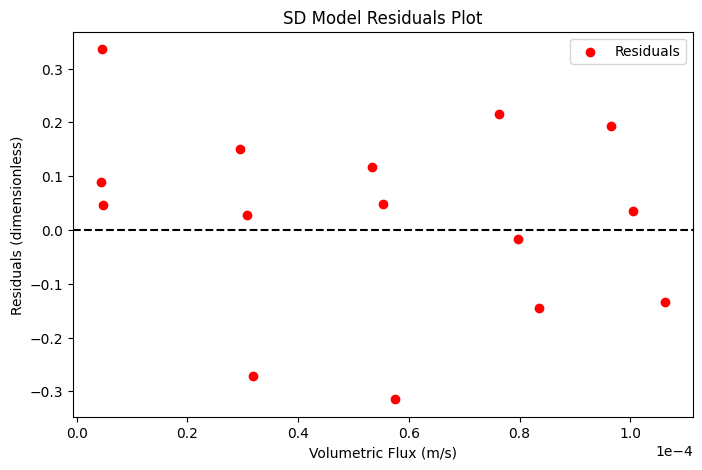

In [5]:
# Calculate the fitted values using the obtained parameters
fitted_values = SD_Model(result.x, J_pred)

# Calculate Rs values from Y
Rs_fitted = fitted_values / (1 + fitted_values)

# Calculate residuals
sd_residuals = Y - SD_Model(result.x, J)

# Plot residuals
plt.figure(figsize=(8, 5))
plt.scatter(J, sd_residuals, color='red', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Volumetric Flux (m/s)')
plt.ylabel('Residuals (dimensionless)')
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title('SD Model Residuals Plot')
plt.show()


###1d. Plot fitted model and Prediction Interval

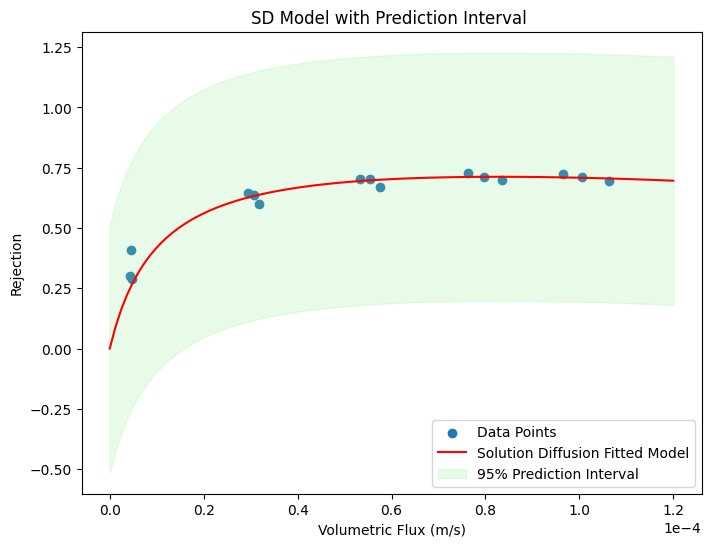

In [6]:
# Calculate standard deviation of residuals
residual_std = np.std(sd_residuals, ddof=len(result.x))

# Degrees of freedom (modify this according to your specific case)
dof = len(J) - len(result.x)

# Calculate t-distribution for 95% prediction interval
t_distribution = t.ppf(0.975, df=dof)
prediction_interval = t_distribution * residual_std * np.sqrt(1 + variance)

# Calculate Rs values from Y
Rs_fitted = fitted_values / (1 + fitted_values)

# Plotting
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(J, Rs, label='Data Points')

# Plot the fitted model
plt.plot(J_pred, Rs_fitted, label='Solution Diffusion Fitted Model', color='red')

# Plotting the prediction interval
plt.fill_between(J_pred, Rs_fitted - prediction_interval, Rs_fitted + prediction_interval,
                 color='lightgreen', alpha=0.2, label='95% Prediction Interval')

plt.xlabel('Volumetric Flux (m/s)')
plt.ylabel('Rejection')
plt.legend(loc='lower right')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title('SD Model with Prediction Interval ')
plt.show()


##2. Speigler Kedem Film Model

The Speigler-Kedem Film Model, unlike the Solution Diffusion Model, introduces a third parameter known as the reflection coefficient. This model accounts for the convective transport through the membrane along with diffusion.

$$
\frac{Rs}{1 - Rs} = \frac{\sigma}{1 - \sigma} \cdot \left(1 - \exp\left(\frac{-J(1 - \sigma)}{\omega}\right) \cdot \exp\left(\frac{-J}{k}\right)\right)
$$

Where:
- ${\sigma}$ represents the reflection coefficient.
- $J $ stands for the volumetric flux
- $\omega$ is the salt permeability
- $k$ denotes the mass transfer coefficient
- $R_s$ signifies salt rejection

For further information about the model you can check the paper: Murthy, Z.V.P., Gupta, Sharad K., “Estimation of mass transfer coefficient using a combined nonlinear membrane transport and film theory model” Desalination, 1997, 113(3), 237-255, https://doi.org/10.1016/S0011-9164(97)00051-9


###2a. Define SK Model

In [7]:

# Define the SK Model equation
def sk_model(x, J):
    '''
    Function to define SK model
    Arguments:
        J: Volumetric Flux in m/s
        x: Estimation Parameter (Reflection coefficient, Salt Permeability, Mass Transfer Coefficient)
    Returns:
        The computed value of Y
    '''

    a1 = x[0] / (1 - x[0])
    a2 = (1 - x[0]) / x[1]
    return a1 * (1 - np.exp(-J * a2)) * (np.exp(-J / x[2]))

def residual_func(x, J, Y):
    return sk_model(x, J) - Y


###2b. Parameter Estimation Using SK Model

For non linear regression here we will again use `least_squares` from `scipy.optimize`

In [8]:
# Initial guess for parameters x0 and parameter bounds
x0 = [0.5, 1e-5, 1e-5]  # Initial guess for [reflection coefficient, salt permeability, mass transfer coefficient]
bounds = ([0, 1e-5, 1e-6], [1, 9e-4, 1e-4])  # Bounds for parameters: [0 to 1], [1e-5 to 1e-6], [1e-5 to 1e-6]

# Perform least squares optimization
result = least_squares(residual_func, x0, bounds=bounds, args=(J, Y))

# Obtained optimized parameters
optimized_params = result.x

# Print Salt permeability and Mass Transfer Coefficient for SK Model
print('\nSalt Permeability:', optimized_params[1], 'm/s')
print('\nMass Transfer Coefficient:', optimized_params[2], 'm/s')


Salt Permeability: 1.1625945932822965e-05 m/s

Mass Transfer Coefficient: 9.999999999999999e-05 m/s


Now calculate the jacobian, variance, and covariance matrix for SK model.

In [9]:
# Evaluating Jacobian Matrix
Jac = result.jac
print('Jacobian Matrix\n', Jac)
# Finding variance using Jacobian Matrix
jac_inv = np.linalg.inv(np.dot(Jac.T, Jac))
vari = J.flatten() - sk_model(result.x, J)
variance = np.var(vari)
print('\nVariance',variance)
# Covariance Matrix
covari= variance * jac_inv
print('\nCovariance Matrix\n',covari)

Jacobian Matrix
 [[ 1.23018700e+01 -1.66260409e+05  2.44379297e+04]
 [ 1.20337228e+01 -1.69092330e+05  2.36431129e+04]
 [ 1.26362022e+01 -1.61895625e+05  2.54737235e+04]
 [ 1.06004280e+01 -1.77837380e+05  1.97272060e+04]
 [ 1.02479548e+01 -1.78782104e+05  1.88243709e+04]
 [ 1.09739760e+01 -1.76381100e+05  2.07061367e+04]
 [ 7.71067446e+00 -1.75271284e+05  1.27913027e+04]
 [ 7.41315326e+00 -1.73757778e+05  1.21299468e+04]
 [ 7.99233013e+00 -1.76492844e+05  1.34257506e+04]
 [ 4.06265061e+00 -1.38796710e+05  5.33001233e+03]
 [ 3.84673652e+00 -1.35163587e+05  4.93790261e+03]
 [ 4.21061236e+00 -1.41167194e+05  5.60248953e+03]
 [ 4.46478520e-01 -3.03341873e+04  1.64900304e+02]
 [ 4.21760656e-01 -2.88996516e+04  1.49095269e+02]
 [ 4.55951389e-01 -3.08780776e+04  1.71118330e+02]]

Variance 0.6376533479503876

Covariance Matrix
 [[ 2.60203040e+01  3.58103201e-04 -1.07015416e-02]
 [ 3.58103201e-04  4.94179115e-09 -1.47159994e-07]
 [-1.07015416e-02 -1.47159994e-07  4.40253694e-06]]


###2c. Residual Plot for SK Model

We will now plot the residual vs Volumetric flux plot for SK Model results.

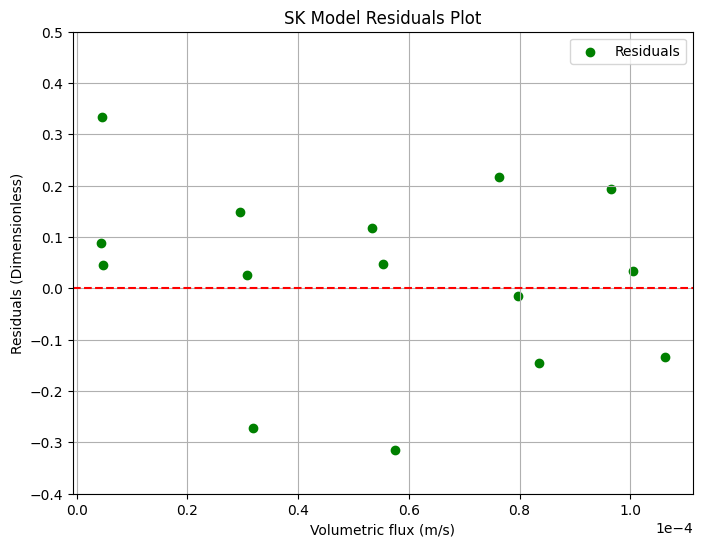

In [10]:
# Calculate the fitted values using the obtained parameters
fitted_values = sk_model(result.x, J_pred)

# Calculate Rs values from Y
Rs_fitted = fitted_values / (1 + fitted_values)

# Calculate residuals
sk_residuals = Y - sk_model(result.x, J)


# Plot the residuals vs Volumetric flux
plt.figure(figsize=(8, 6))
plt.scatter(J, sk_residuals, color='green', label='Residuals')
plt.xlabel('Volumetric flux (m/s)')
plt.ylabel('Residuals (Dimensionless)')
plt.title('SK Model Residuals Plot')
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-0.4, 0.5)
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.grid(True)
plt.show()



###2d. SK Model Fitting Plot and Prediction Interval

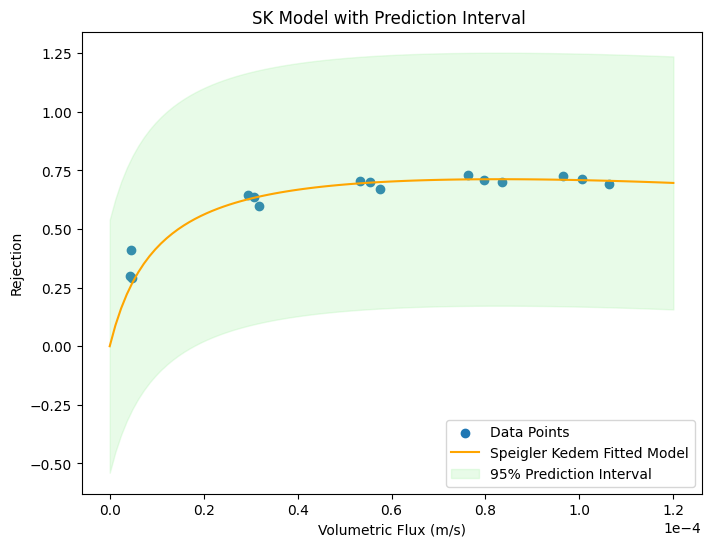

In [11]:
# Calculate standard deviation of residuals
residual_std = np.std(sk_residuals, ddof=len(result.x))

# Degrees of freedom (modify this according to your specific case)
dof = len(J) - len(result.x)

# Calculate t-distribution for 95% prediction interval
t_distribution = t.ppf(0.975, df=dof)
prediction_interval = t_distribution * residual_std * np.sqrt(1 + variance)

# Calculate Rs values from Y
Rs_fitted = fitted_values / (1 + fitted_values)

# Plotting
plt.figure(figsize=(8, 6))

# Plot the data points
plt.scatter(J, Rs, label='Data Points')

# Plot the fitted model
plt.plot(J_pred, Rs_fitted, label='Speigler Kedem Fitted Model', color='orange')

# Plotting the prediction interval
plt.fill_between(J_pred, Rs_fitted - prediction_interval, Rs_fitted + prediction_interval,
                 color='lightgreen', alpha=0.2, label='95% Prediction Interval')

plt.xlabel('Volumetric Flux (m/s)')
plt.ylabel('Rejection')
plt.legend(loc='lower right')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title('SK Model with Prediction Interval ')
plt.show()


##3. Comparision: SD Model vs SK Model

Now we will do a statistical comparison of the SD model (two parameter model) and SK Model (three parameter model) using Akaike's Information Criterion.

###3a. Akaike's Information Criterion (AIC)

Akaike's Information Criterion (AIC) is a measure used for model selection that balances model fit and complexity. It quantifies the trade-off between the goodness of fit and the number of parameters in a statistical model.

The equation for AIC is:

$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$

Where:
**k** is the number of estimated parameters in the model.
**L** is the maximum value of the likelihood function for the model.

This way, lower AIC indicates a better trade-off between model fit and complexity. So, among competing models, the one with the lowest AIC is considered to be the best in balancing goodness of fit and simplicity.

For small sample size AIC can be modified for better estimation by the following equation:

$$
\text{AICc} = AIC + {\frac{((2k)^2 +2k)}{n - k -1}}
$$

After the AIC is evaluated, we can perform f test if the error is higher for the preferred model justify the statistical comparison.


In [12]:


# Define a function for AIC

def aic_f(k1,k2,rss_sd, rss_sk):
        if k2+1 >= n:
            print('number of observations should be 2 more than fitting parameter to perform AIC or f test')
        else:
            aic_sd = 2*k1 + n*np.log(rss_sd/n)
            # AIC corrected for small no. of observation points
            num = 2*(k1)**2 + 2*k1
            denom = n - k1 - 1
            #AIC for SD Model
            AICc_sd = aic_sd + (num/denom)

            #AIC for SK Model
            aic_sk = 2*k2 + n*np.log(rss_sk/n)
            num = 2*(k2)**2 + 2*k2
            denom = n - k2 - 1
            AICc_sk = aic_sk + (num/denom)
            print('AIC for SD model is ', AICc_sd)
            print('AIC for SK model is ', AICc_sk)
            if AICc_sd < AICc_sk:
                print('AIC - SD model is better fit to the data than SK model' )
            else:
                print('AIC - SK model is better fit to the data than SD model' )


  # F-Test
 # calculated f is greater than f critical and p value less than alpha(0.05) then null hypothesis is rejected
            if rss_sd > rss_sk:
                n1 = (rss_sd - rss_sk)/ (fp2 - fp1)
                d1 = (rss_sk) / (n - fp2)
                ft = n1 / d1
                p_value = 1-stats.f.cdf(ft, (fp2-fp1), (n-fp2))
                f_critical = stats.f.ppf(q=1-alpha, dfn= fp2-fp1 , dfd= n-fp2)
                print('\nf=',ft, '\nf*=',f_critical, '\np_value=', p_value)


                if ft < f_critical and p_value >= alpha :
                    print('F Test - SD model fits better to the data than SK model ')
                else:
                    print ('F Test -SK model fits better to the data than SD model')
            else:
                print('f test - SD model has low error and fits better than SK model')

        return


Now call the AIC function to compare the model

In [13]:
fp1 = 2  #  number of fitted parameter in SD MODEL
fp2 = 3 # number of fitted parameter in SK MODEL

n = len(Y)    # number of data points
p = len(optimized_params) # number of parameters
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

# k1 for SD and k2  SK is number of fitted parameter + 1, used for AIC
k1= fp1+1
k2 = fp2 +1

rss_sk = sum(sk_residuals)**2 # residual sum of squares for SK model
rss_sd = sum((sd_residuals)**2) # residual sum of squares for SD model


# Call the AIC function
aic_f(k1,k2,rss_sd, rss_sk)

AIC for SD model is  -44.10766253375572
AIC for SK model is  -58.221060291972066
AIC - SK model is better fit to the data than SD model

f= 27.660085868866968 
f*= 4.747225346722511 
p_value= 0.00020131060639594356
F Test -SK model fits better to the data than SD model


##4. Discussion

Question 1: According to your estimation, is there a significant difference when using three parameter model (SK Model) vs two parameter model (SD Model)? Which one do you think is better for this data?

Answer: Although the models looks really similar in terms of output, the SK model here gives a better estimation than SD model. This can be verified by the AIC and f test results and we can conclude that convective transport is important to consider for this set of data.

Question 2: Do the two membrane transport models give the same or different estimates for Salt Permeability and Mass Transfer Coefficient ?

Answer: The two models gives different values for Salt Permeability and Mass Transfer Coefficient. However, the estimated values are close to each other.

Question 3: Why do you think the residual are dimensionless for the data? Justify in one or two sentences

Answer: Residual in the above data is for the rejection data. The rejection in itself is dimensionless.




##References
1. Wijmans, J.G., Baker, R.W., “The solution-diffusion model: a review” Journal of Membrane Science, 1995 107, 1-21, https://doi.org/10.1016/0376-7388(95)00102-I
2. Haim, O.P., Shefer, I., Singh, P., Nir, O., Epsztein, R., “The adverse effect of concentration polarization on ion-ion selectivity in Nanofiltration” Environmental Science and Technology Letters, 2023 10 (4), 363-371, https://doi.org/10.1021/acs.estlett.3c00124
3. Murthy, Z.V.P., Gupta, Sharad K., “Estimation of mass transfer coefficient using a combined nonlinear membrane transport and film theory model” Desalination, 1997 109 (1), 39-49, https://doi.org/10.1016/S0011-9164(97)00051-9
